In [1]:
import os
import argparse
import logging
import time
import numpy as np
import numpy.random as npr
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import copy
import cv2
from torchvision import transforms
from scipy.ndimage.interpolation import zoom
import itertools
import pickle
from torchdiffeq import odeint_adjoint as odeint
from scipy.integrate import solve_ivp
from IPython import display 
device = torch.device('cuda')

In [2]:
def diffeq(t, x):
    x0 = torch.tensor(x).clone().detach()

    x1 = x0.clone().detach()
    x1.requires_grad = True
    f1 = F1(x1,p)
    f1.backward()
    grad1 = x1.grad

    x2 = x0.clone().detach()
    x2 = x2 + torch.tensor([2,1])
    x2.requires_grad = True
    f2 = F2(x2,p)
    f2.backward()
    grad2 = x2.grad 

    dudt = -1*(1-Chi(x0))*p[4]*grad1[0] - Chi(x0)*p[5]*grad2[0]
    dvdt = -1*(1-Chi(x0))*p[4]*grad1[1] - Chi(x0)*p[5]*grad2[1]

    if isinstance(dudt, torch.Tensor):
        A = [dudt.numpy(), dvdt.numpy()]
    else:
        A = [dudt, dvdt]
    return A

def F1(x, p):
    u = x[0]
    v = x[1]
    f = u**4 + v**4 + v**3 - 4*u**2*v + v**2 + p[0]*u + p[1]*v
    return f

def F2(x, p):
    u = x[0]
    v = x[1]
    f = u**4 + v**4 - u**3 + 2*v**2*u - u**2 - p[2]*u + p[3]*v
    return f

def Chi(x):
    res = (np.tanh(10*(x[0]-0.5))+1)/2
    return res


In [3]:
%run Supporting_Function.py
%run ODE_Func.py
%run Ploting_Function.py

In [4]:
domains = (
    [-1.5, 4, -1.5, 4], 
    [0.5, 4, -1.5, 4]
)
p = [0.5 for i in range(6)]


In [11]:
for i in range(2):
    samp_coord, samp_eq = sample_Eq(1000, diffeq, [-3, 2, -3, 3])

    if i == 0:
        epoch_coord = samp_coord
        epoch_eq = samp_eq
    else:
        epoch_coord = np.stack((epoch_coord, samp_coord), axis = 0)
        epoch_eq = np.stack((epoch_eq, samp_eq), axis = 0)

    epoch_coord = torch.from_numpy(epoch_coord).float().to(device)
    epoch_eq = torch.from_numpy(epoch_eq).float().to(device)


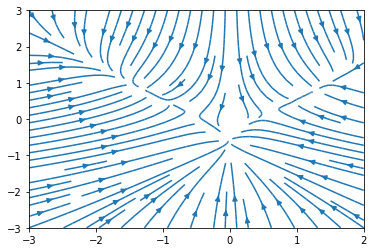

In [8]:
size = 100
X = np.linspace(-3, 2, size)
Y = np.linspace(-3, 3, size)
coord = np.array(np.meshgrid(X, Y)).reshape(2, size**2)
h = np.zeros([2, size**2])

for i in range(size**2):
    h[:,i] = diffeq(0, coord[:,i])

coord = coord.reshape(2, size, size)
h = h.reshape(2, size, size)
plt.streamplot(coord[0,:,:], coord[1,:,:], h[0,:,:], h[1,:,:])
plt.show()

In [33]:
func = ODEFunc(2, 100, 100, nlayer_M = 3, nlayer_V= 3, n_V=6)
# func.apply(init_weights)
params = list(func.parameters())
optimizer = optim.Adam(params, lr=lr)
lr = 0.1
loss_meter = RunningAverageMeter()
min_loss = inf 

In [41]:
np.shape(samp_eq)

torch.Size([1000, 2])

In [ ]:
try:

    for itr in range(1, 100000):
        optimizer.zero_grad()
        samp_coord_grad = epoch_coord[i,:,:].detach().requires_grad_(True)
        samp_eq = epoch_eq[i,:,:]
        L2 = ((func(0, samp_coord_grad)-samp_eq)**2).sum()
        loss = L2
        loss.backward()
        optimizer.step()
        loss_meter.update(loss.item())

        display.clear_output()
        print('Iter: {}, MSE loss: {:.4f}'.format(itr, -loss_meter.avg))
    
        if loss_meter.avg <= min_loss:
            torch.save(func, 'min_func_Saez.pt')
            min_loss = loss_meter.avg
            print("min model_updated") 

except KeyboardInterrupt:

    print('Training complete after {} iters.'.format(itr))

In [308]:
np.shape(epoch_eq)

torch.Size([2, 10, 2])

In [14]:
min_func = torch.load('min_func_LC.pt')

In [27]:
torch.save(min_func, 'min_func_LC_03_25.pt')

C:\Users\Firelovesnow\Anaconda3\lib\site-packages\torch\serialization.py:402: UserWarning: Couldn't retrieve source code for container of type ODEFunc. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


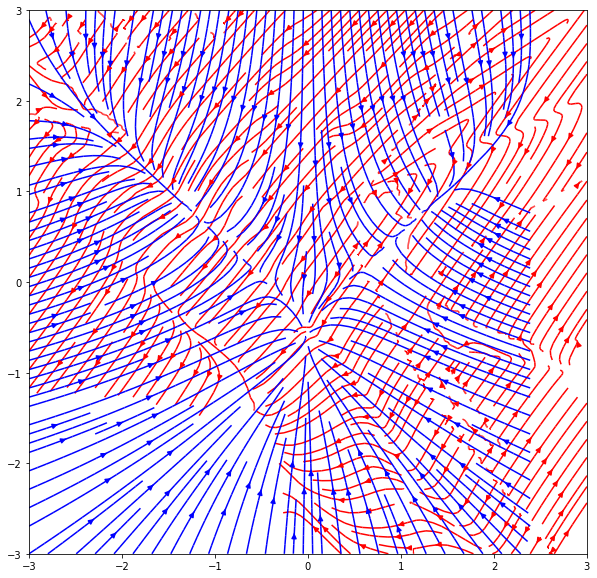

In [35]:
plot_func_no_vectorized(func, diffeq, domain = [-3, 3])

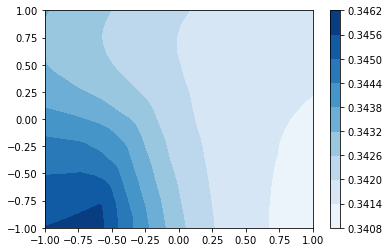

In [48]:
plot_V(min_func, continuous=False)

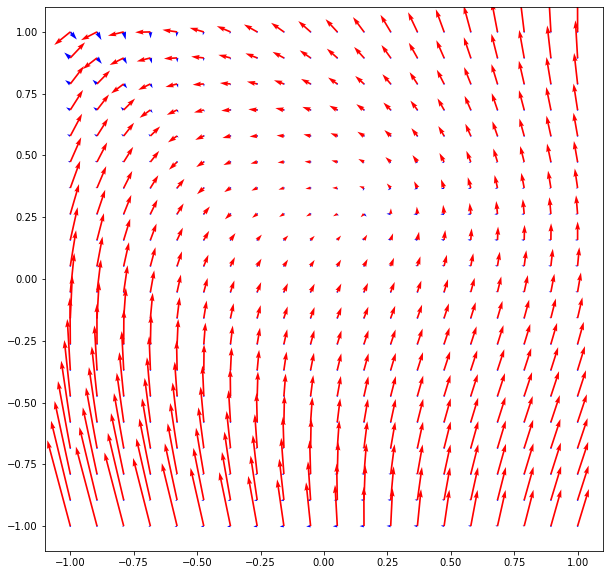

In [25]:
plot_Eigval(min_func)

In [53]:
for i in range(10):
    func = ODEFunc(2, 40, 40, nlayer_V= 2, n_V=3)
    # func.apply(init_weights)
    lr = 0.01
    N_grad = N.detach().requires_grad_(True)
    params = list(func.parameters())
    optimizer = optim.Adam(params, lr=lr)
    loss_meter = RunningAverageMeter()
    pred_steps = 500
    OldParams = None
    min_loss = 10000000
    lmbda = 0.01

    for itr in range(1, 20000):
        optimizer.zero_grad()

        L2 = ((func(0,N_grad) - V_norm)**2).sum()
        a,b,c,d = func.metric_nn(N_grad).split(1,1)
        L1 = torch.log((a*d-b*c)**2).sum()
        loss = L2 - lmbda*L1
        loss.backward()
        optimizer.step()
        loss_meter.update(loss.item())

        NewParams = plot_params(params, plot = False)
        update_bool = True
        if OldParams is not None:
          update_bool = not (NewParams==OldParams).all()
        OldParams = NewParams
        display.clear_output()
        print('Iter: {}, MSE loss: {:.4f}, Update Param: {}'.format(itr, -loss_meter.avg, update_bool))

        if loss_meter.avg < min_loss:
          name = 'min_func_' + str(i) + '.pt' 
          torch.save(func, name)

Iter: 19999, MSE loss: -7889.7938, Update Param: True


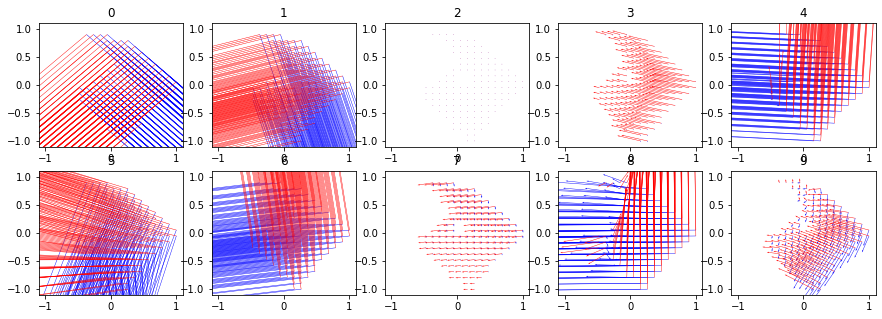

In [49]:
fig, axs = plt.subplots(2, 5)
fig.set_figheight(5)
fig.set_figwidth(15)
n = 10
for i,j in itertools.product(range(2),range(5)):
  name_str = 'min_func_' + str(i*5+j) + '.pt'
  func = torch.load(name_str)
  coord, eigvec1, eigvec2 = get_data_eig(func, 20, 2, eig_type = 'vector')
  x, y = coord
  u1, v1 = eigvec1
  u2, v2 = eigvec2
  axs[i,j].quiver(x,y,u1,v1, color= 'b',angles='xy', scale_units='xy', scale=10**n)
  axs[i,j].quiver(x,y,u2,v2, color='r',angles='xy', scale_units='xy', scale=10**n)
  axs[i,j].set_title(str(i*5+j))

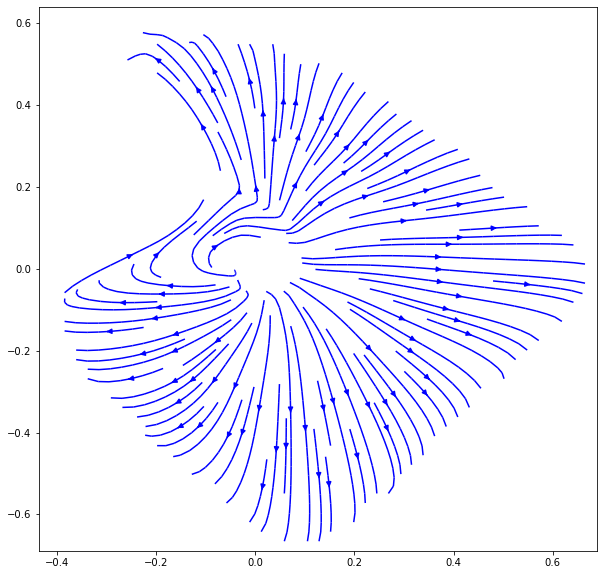

In [52]:
func = torch.load('min_func_0.pt')
plot_func(func)